CODE FOR TRAINING THE MODEL

LIBRARY IMPORTS

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from sklearn.utils import class_weight
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2


LOADING DATA

In [17]:
data_dirs = {
    "URTI": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\URTI",
    "Healthy": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Healthy",
    "COPD": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\COPD",
    "Bronchiectasis": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Bronchiectasis",
    "Pneumonia": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Pneumonia",
    "Bronchiolitis": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Bronchiolitis"
}

for disease, path in data_dirs.items():
    print(f"Loaded {disease} data directory: {path}")

# Load data and labels
X = []  # Spectrograms
y = []  # Labels

for label, folder_path in data_dirs.items():
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".npy"):
            file_path = os.path.join(folder_path, file_name)
            data = np.load(file_path)  # Shape: (128, 128, 1)
            X.append(data)
            y.append(label)

# Convert to numpy arrays
X = np.array(X)  # Shape: (n_samples, 128, 128, 1)
y = np.array(y)  # Shape: (n_samples,)

print("\nCounting number of files in each directory:\n")
for disease, path in data_dirs.items():
    count = len([f for f in os.listdir(path) if f.endswith(".npy")])
    print(f"{disease}: {count} files")


Loaded URTI data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\URTI
Loaded Healthy data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Healthy
Loaded COPD data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\COPD
Loaded Bronchiectasis data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Bronchiectasis
Loaded Pneumonia data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Pneumonia
Loaded Bronchiolitis data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Bronchiolitis

Counting number of files in each directory:

URTI: 648 files
Healthy: 712 files
COPD: 646 files
Bronchiectasis: 499 files
Pneumonia: 700 files
Bronchiolitis: 520 files


ENCODING LABELS

In [22]:
# 1. Label Encoding (your existing code)
label_encoder = LabelEncoder()
label_encoder.fit(y)  # Fit on all labels
y_encoded = label_encoder.transform(y)  # Transform all labels

print(f'\nTotal spectrograms: {len(X)}')
print("Label mapping:", dict(zip(label_encoder.classes_, 
                               label_encoder.transform(label_encoder.classes_))))
print("\nClass distribution:")
print(pd.Series(y).value_counts())


Total spectrograms: 3725
Label mapping: {'Bronchiectasis': 0, 'Bronchiolitis': 1, 'COPD': 2, 'Healthy': 3, 'Pneumonia': 4, 'URTI': 5}

Class distribution:
Healthy           712
Pneumonia         700
URTI              648
COPD              646
Bronchiolitis     520
Bronchiectasis    499
Name: count, dtype: int64


SPLIT TRAIN-EVALUATE-TEST DATA

In [23]:
# 2. Stratified Train-Val Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    stratify=y_encoded,
    random_state=42
)

# 3. Class Weight Calculation
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("\nClass weights (1 = balanced):")
for i, cls in enumerate(label_encoder.classes_):
    print(f"{cls}: {class_weights[i]:.2f}")


Class weights (1 = balanced):
Bronchiectasis: 1.24
Bronchiolitis: 1.19
COPD: 0.96
Healthy: 0.87
Pneumonia: 0.89
URTI: 0.96


CNN-MODEL

In [24]:

def create_model():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               input_shape=(128, 128, 1), kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Classification head
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(6, activation='softmax')
    ])
    
    optimizer = AdamW(learning_rate=0.0001, weight_decay=1e-4)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

model = create_model()
model.summary()

C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 323,814 (1.24 MB)

 Trainable params: 322,406 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

TRAIN MODEL

In [26]:
epochs = 100
batch_size = 32

callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# 5. Training with Class Weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# 6. Post-Training Analysis
print("\nMaximum Validation Accuracy: {:.2f}%".format(
    max(history.history['val_accuracy']) * 100))

Epoch 1/100


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InvalidArgumentError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\framework\errors_impl.py(284): __init__
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\execute.py(53): quick_execute
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\context.py(1683): call_function
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py(251): call_flat
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py(216): call_preflattened
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\polymorphic_function\concrete_function.py(1322): _call_flat
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(919): _call
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(833): __call__
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\util\traceback_utils.py(150): error_handler
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py(216): function
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py(368): fit
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py(117): error_handler
  C:\Users\Jiary\AppData\Local\Temp\ipykernel_12304\3535872538.py(22): <module>
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py(3549): run_code
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py(3489): run_ast_nodes
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py(3306): run_cell_async
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py(128): _pseudo_sync_runner
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py(3102): _run_cell
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py(3047): run_cell
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py(549): run_cell
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py(449): do_execute
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py(778): execute_request
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py(362): execute_request
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py(437): dispatch_shell
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py(534): process_one
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py(545): dispatch_queue
  c:\Program Files\Python311\Latest\Lib\asyncio\events.py(84): _run
  c:\Program Files\Python311\Latest\Lib\asyncio\base_events.py(1936): _run_once
  c:\Program Files\Python311\Latest\Lib\asyncio\base_events.py(608): run_forever
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py(205): start
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py(739): start
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py(1075): launch_instance
  C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py(18): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


EVALUATE

In [ ]:
# Initialize lists to store fold results
val_accuracies = []
val_losses = []

# Loop through history_list (containing results of each fold)
for fold, history in enumerate(history_list):
    val_accuracy = history.history['val_accuracy'][-1]  # Last value of val_accuracy for each fold
    val_loss = history.history['val_loss'][-1]  # Last value of val_loss for each fold
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    
    print(f"Fold {fold + 1} - Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}")

# Calculate the average performance across all folds
avg_val_accuracy = np.mean(val_accuracies)
avg_val_loss = np.mean(val_losses)

print(f"\nAverage Validation Accuracy across all folds: {avg_val_accuracy}")
print(f"Average Validation Loss across all folds: {avg_val_loss}")


Fold 1 - Validation Accuracy: 0.37265416979789734, Validation Loss: 1.592278242111206
Fold 2 - Validation Accuracy: 0.43431636691093445, Validation Loss: 1.3244121074676514
Fold 3 - Validation Accuracy: 0.5361930131912231, Validation Loss: 1.284045696258545
Fold 4 - Validation Accuracy: 0.2841823101043701, Validation Loss: 1.741123080253601
Fold 5 - Validation Accuracy: 0.31099194288253784, Validation Loss: 1.6787183284759521
Fold 6 - Validation Accuracy: 0.4650537669658661, Validation Loss: 1.2441452741622925
Fold 7 - Validation Accuracy: 0.3172042965888977, Validation Loss: 1.7817497253417969
Fold 8 - Validation Accuracy: 0.2956989109516144, Validation Loss: 1.7606309652328491
Fold 9 - Validation Accuracy: 0.4838709533214569, Validation Loss: 1.3066973686218262
Fold 10 - Validation Accuracy: 0.32258063554763794, Validation Loss: 1.5265967845916748

Average Validation Accuracy across all folds: 0.3822746366262436
Average Validation Loss across all folds: 1.5240397572517395


PLOTS


--- Fold 1 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372


C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

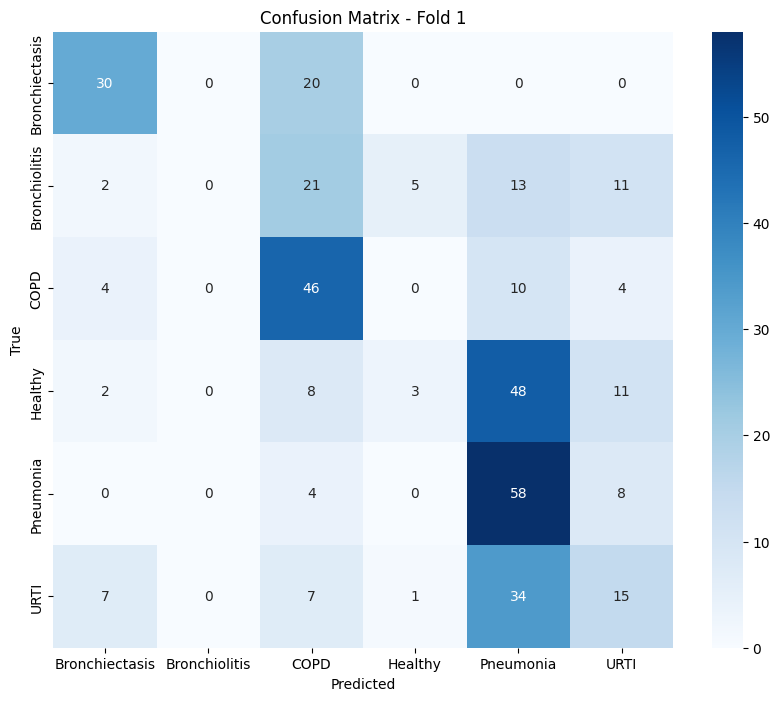

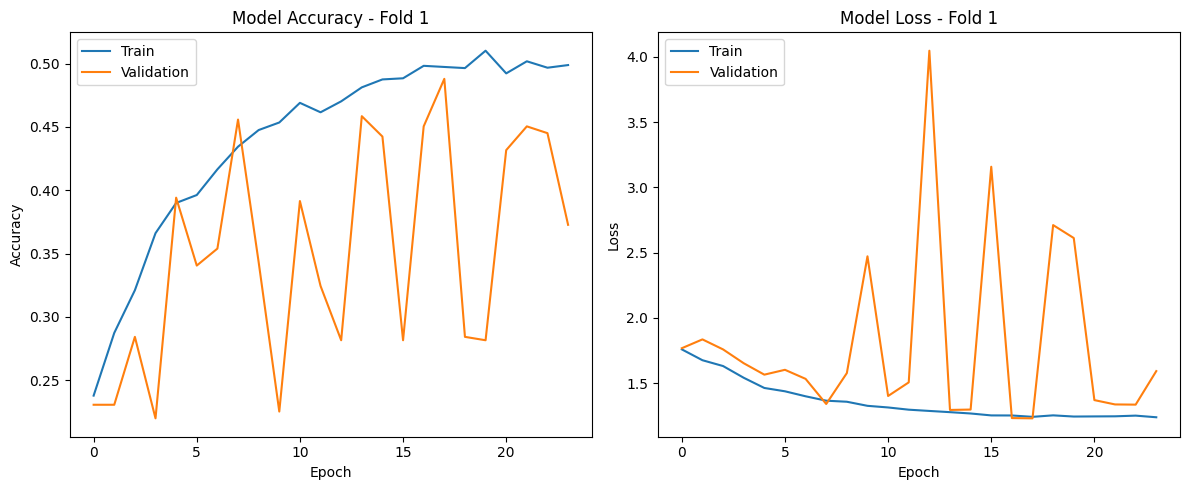


--- Fold 2 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372



C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

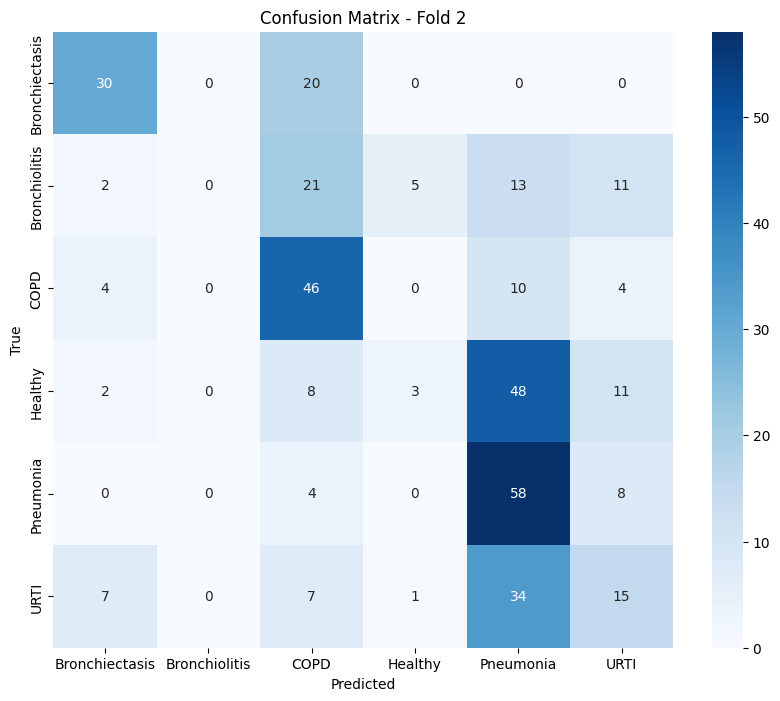

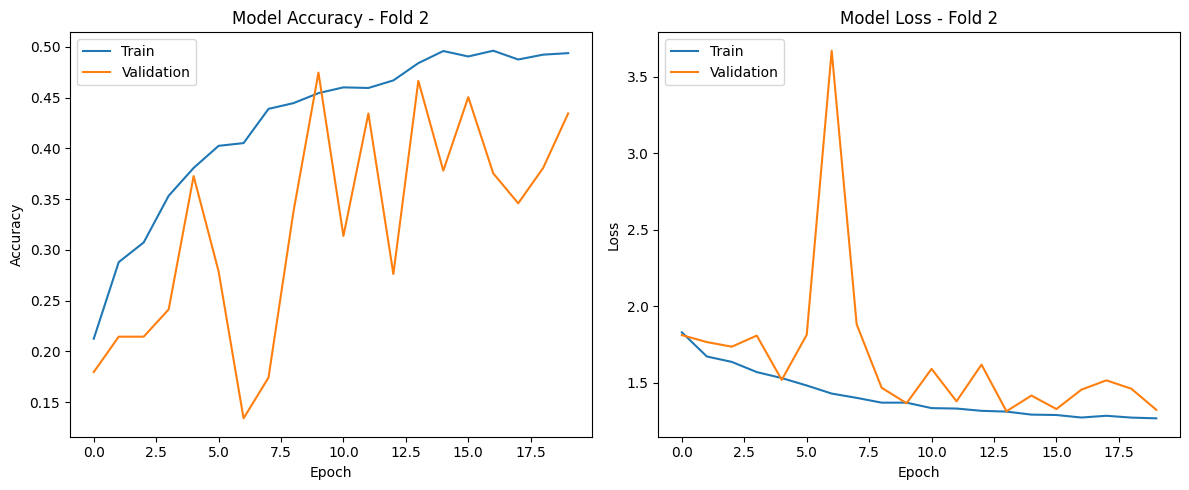


--- Fold 3 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372



C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

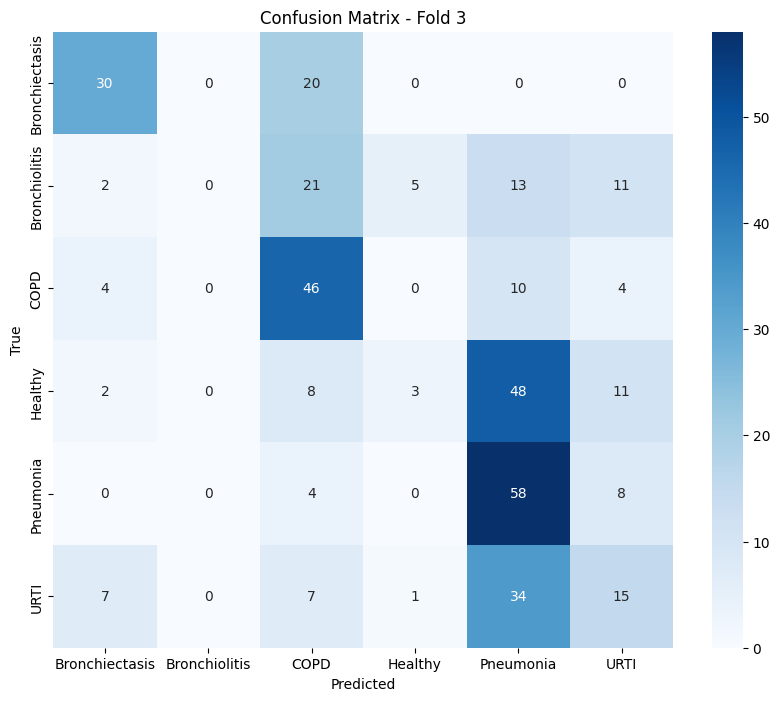

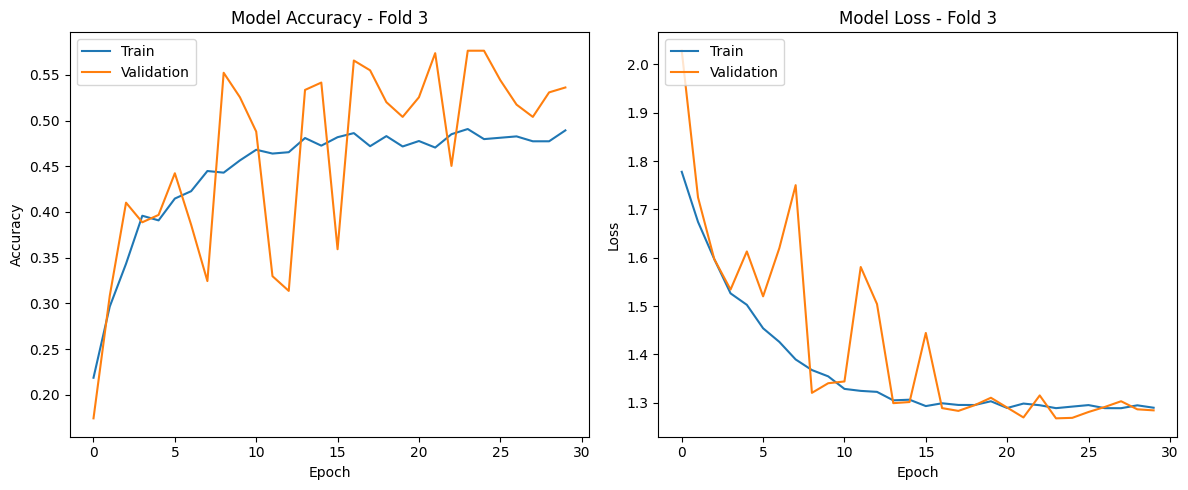


--- Fold 4 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372



C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

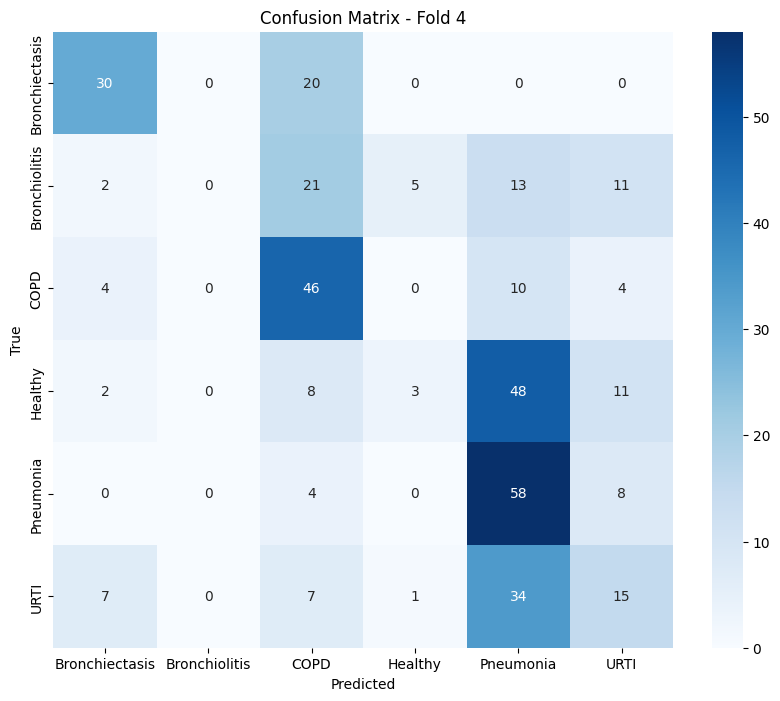

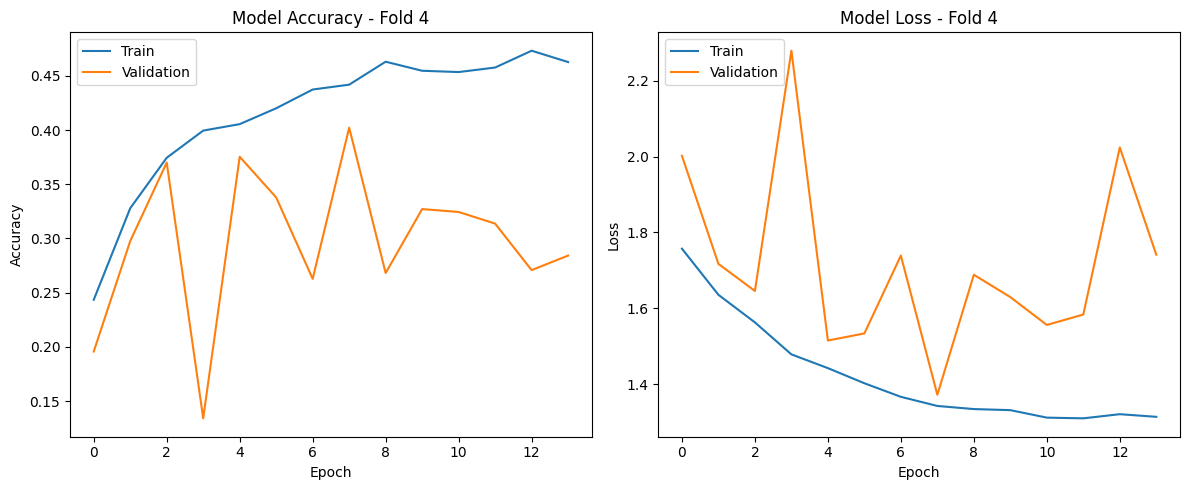


--- Fold 5 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372



C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

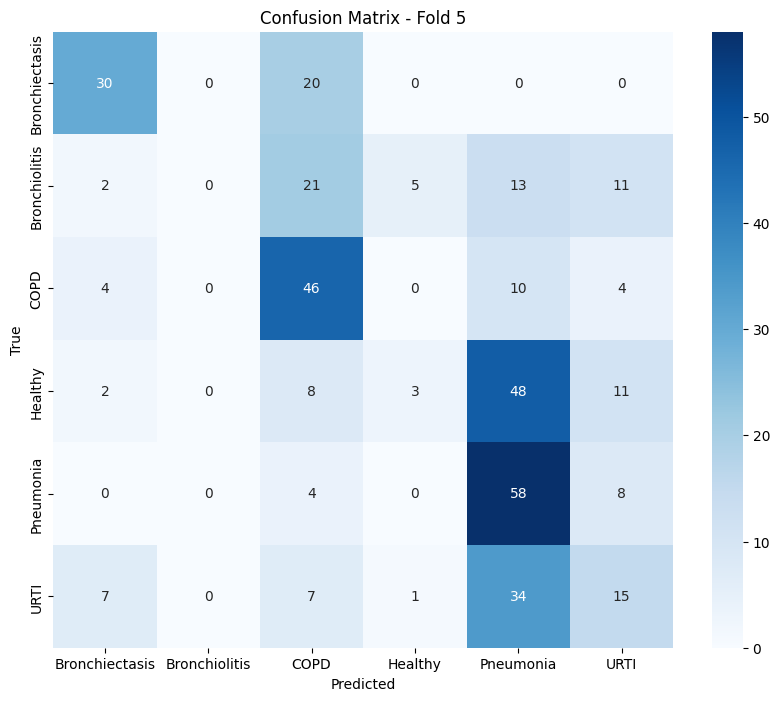

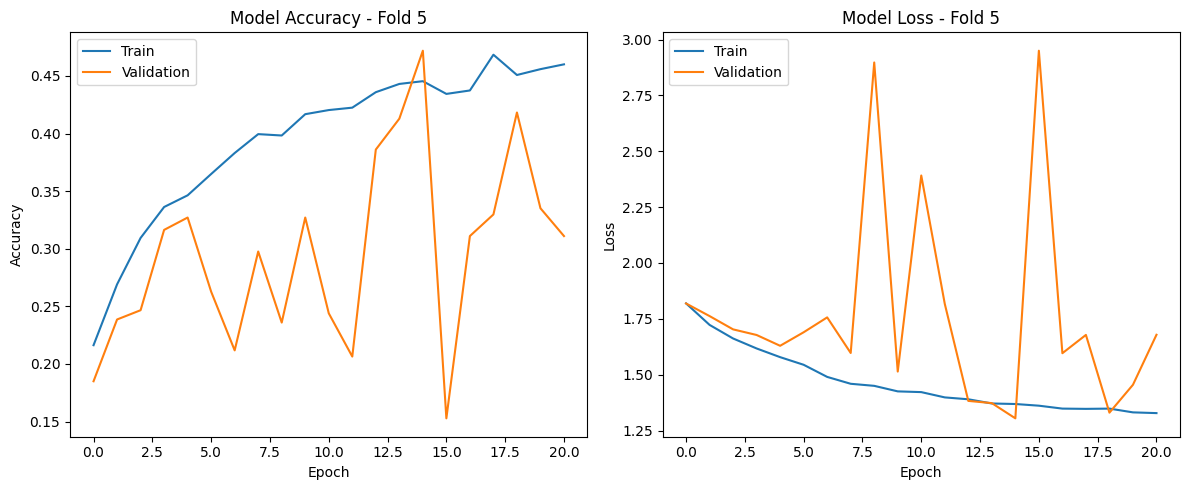


--- Fold 6 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372



C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

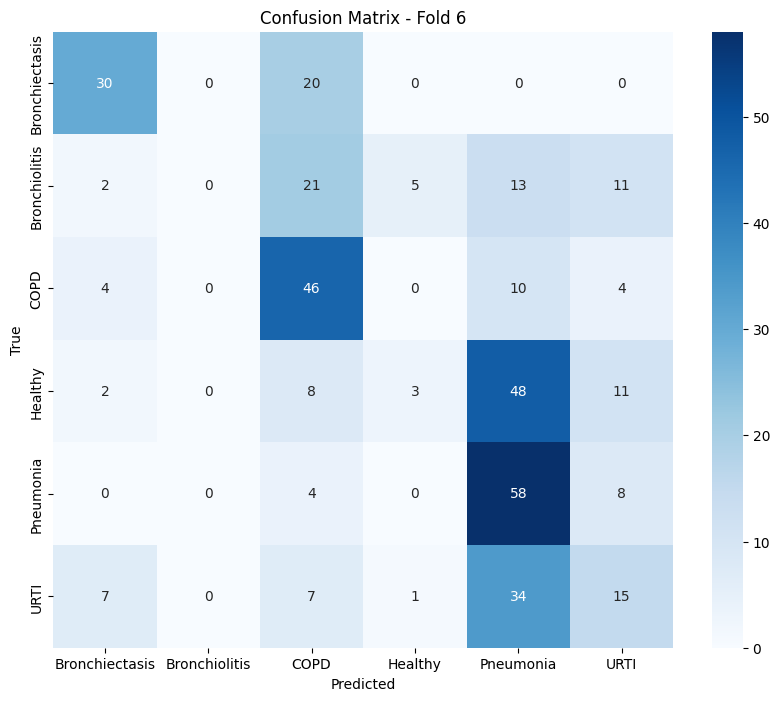

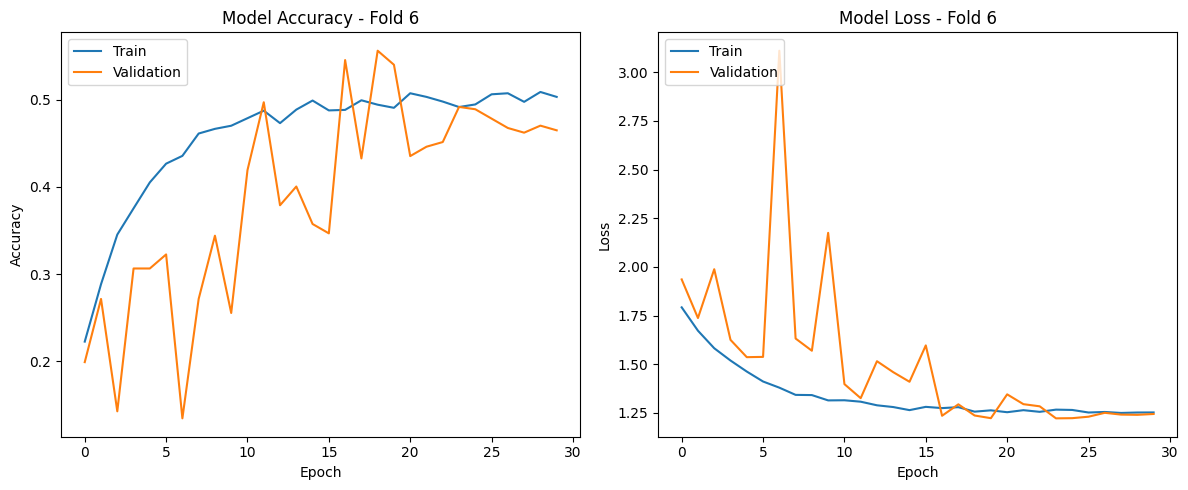


--- Fold 7 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372



C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

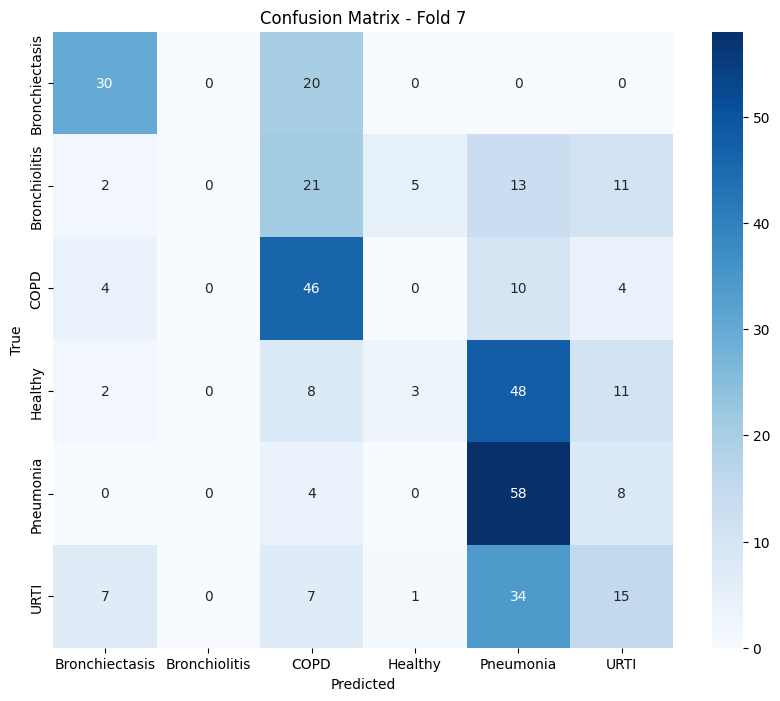

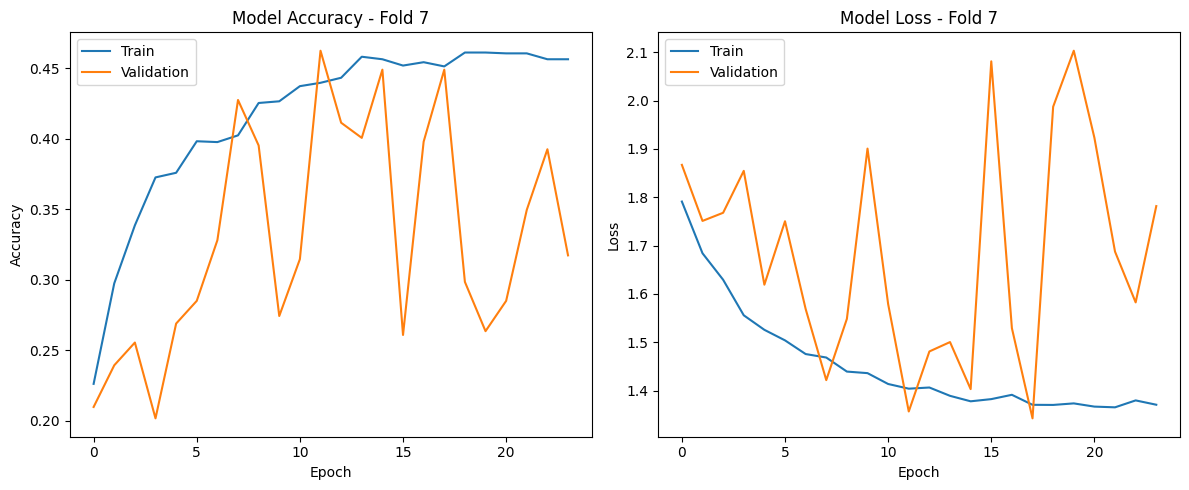


--- Fold 8 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372



C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

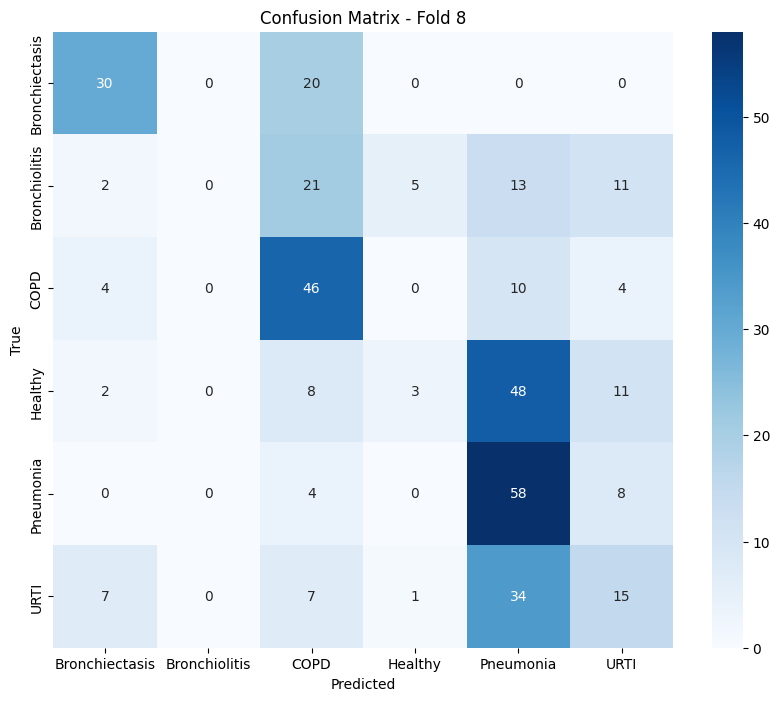

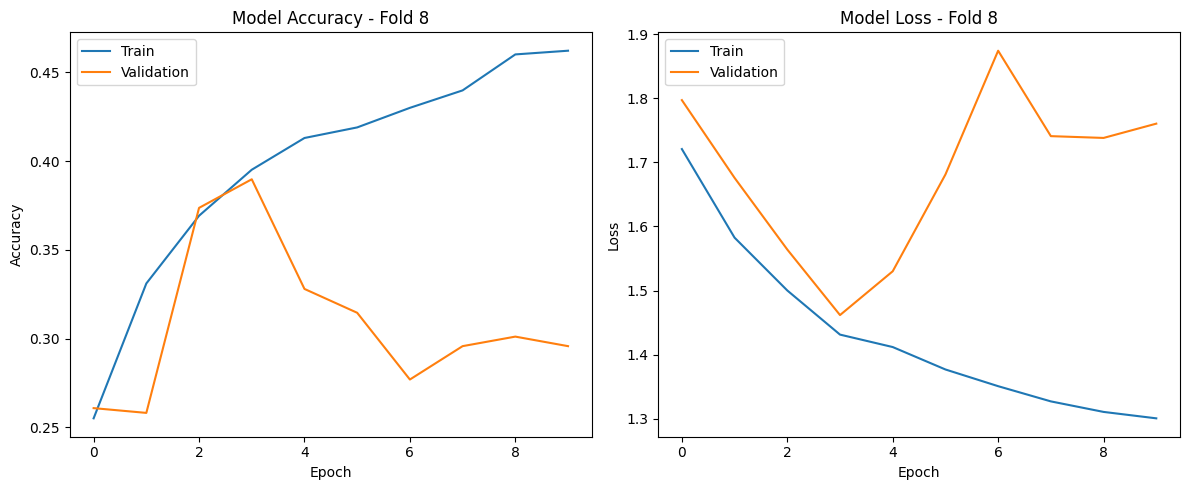


--- Fold 9 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372



C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

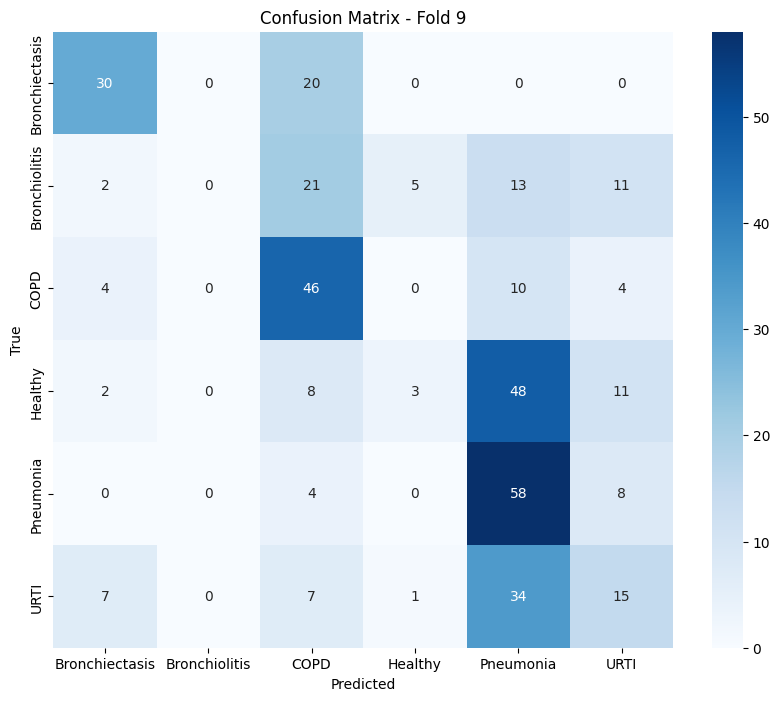

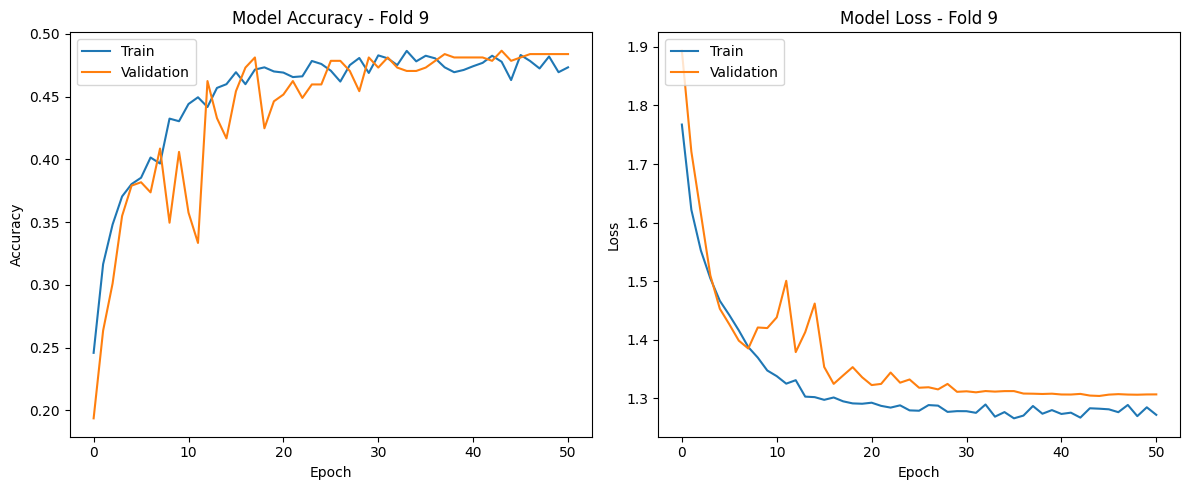


--- Fold 10 ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.60      0.63        50
 Bronchiolitis       0.00      0.00      0.00        52
          COPD       0.43      0.72      0.54        64
       Healthy       0.33      0.04      0.07        72
     Pneumonia       0.36      0.83      0.50        70
          URTI       0.31      0.23      0.27        64

      accuracy                           0.41       372
     macro avg       0.35      0.40      0.34       372
  weighted avg       0.35      0.41      0.33       372



C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jiary\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

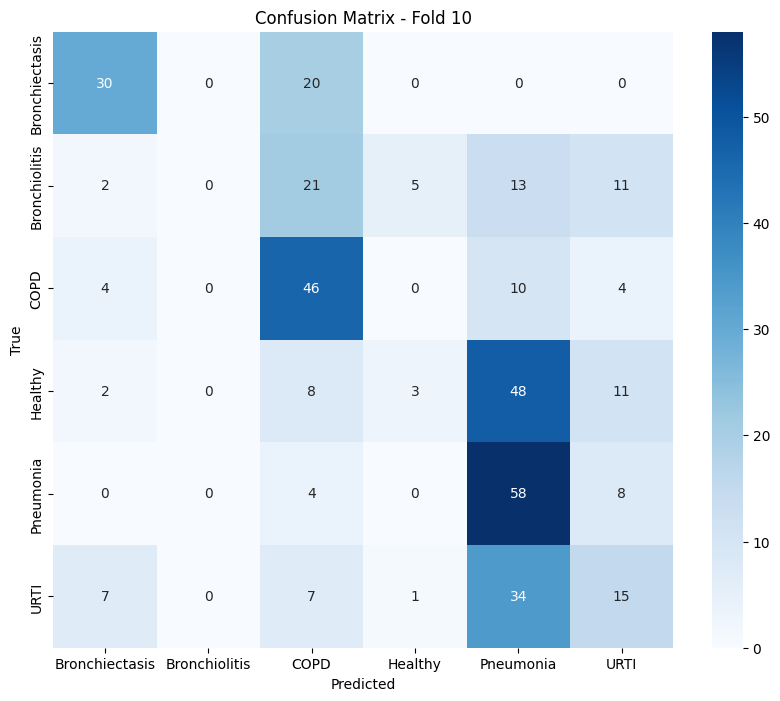

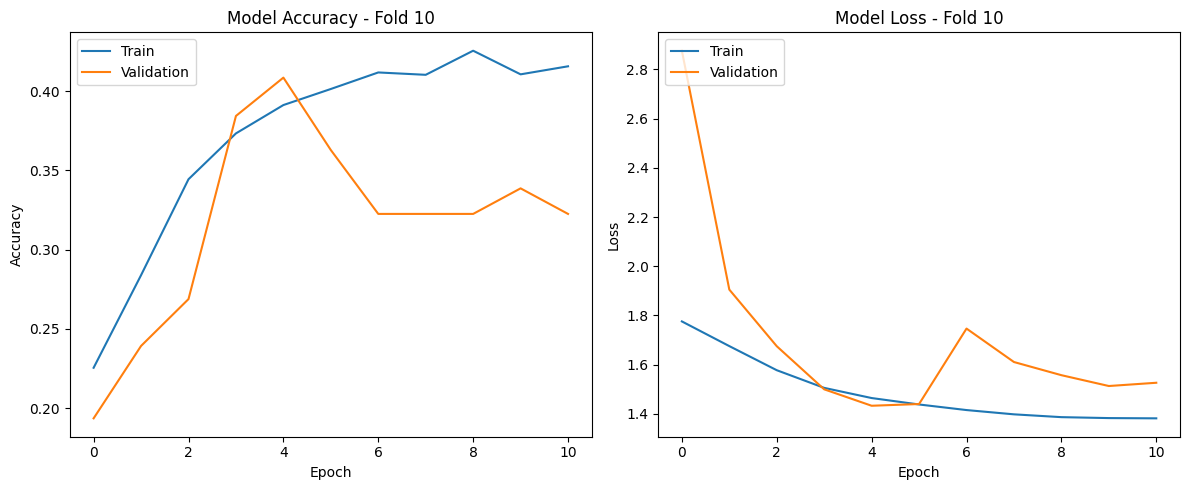


Average Validation Accuracy across all folds: 0.3822746366262436
Average Validation Loss across all folds: 1.5240397572517395


In [ ]:
# Initialize lists to collect metrics
all_val_accuracies = []
all_val_losses = []

# Loop through each fold's history and generate classification reports and confusion matrices
for fold, history in enumerate(history_list):
    print(f"\n--- Fold {fold + 1} ---")

    # Get predictions for this fold (validation set)
    y_pred = model.predict(X_val)  # X_val comes from the current fold
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Classification Report for this fold
    print("Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix for this fold
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Plot training history (accuracy and loss) for this fold
    plt.figure(figsize=(12, 5))

    # Accuracy plot for this fold
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy - Fold {fold + 1}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot for this fold
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss - Fold {fold + 1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    # Save metrics for this fold
    all_val_accuracies.append(history.history['val_accuracy'][-1])
    all_val_losses.append(history.history['val_loss'][-1])

# After all folds, print aggregate results
print(f"\nAverage Validation Accuracy across all folds: {np.mean(all_val_accuracies)}")
print(f"Average Validation Loss across all folds: {np.mean(all_val_losses)}")


SAVE MODEL

In [ ]:
model.save('respiratory_cnn_model.h5')

In [ ]:
import os

# Get the absolute path of the saved model
model_path = os.path.abspath('respiratory_cnn_model.h5')
print(f"The model is saved at: {model_path}")

The model is saved at: c:\Users\Jiary\Documents\GitHub\ML\Project\respiratory_cnn_model.h5
